In [142]:
import visa
rm = visa.ResourceManager("/Library/Frameworks/Visa.framework/VISA")
K6220 = rm.open_resource('GPIB0::12::INSTR')
K2400 = rm.open_resource('GPIB0::13::INSTR')
print K6220.query('*IDN?'), K2400.query('*IDN?')


KEITHLEY INSTRUMENTS INC.,MODEL 6220,1347935,A05  /700x 
KEITHLEY INSTRUMENTS INC.,MODEL 2400,1386470,C32   Oct  4 2010 14:20:11/A02  /S/K



In [149]:
from import_all import *
import time
def c_lab_conductivity(path, filname,
                       curr_start=-1e-3, curr_stop=1e-3, curr_step=1e-4,
                       sour_del=.01, nplc=1, graph=True, 
                       bias_curr=0., c_cmpl=1., v_cmpl=10.,
                       swp_rang='BEST', swe_coun=1):
    """Do conductivity measurment with KE6220 (current source) and KE2400 (source meter)
    
    DON'T change sour_del and nplc from the default value unless
    you really need it.
    Total step number should be not more than 21.
    Syncronizing two sweeps is tricky!
    
    Args:
    path: string, path of the directory to save file
    filename: string, filename
    curr_start: float, current start value [A]
    curr_stop: float, current stop value [A]
    curr_step: float, current sweep step [A]
    sour_del: float, source deley [s]
    nplc: float, nplc, if nplc=1, signal is integrated for 16.67 ms [-]
    graph: boolan, if True, a V-I plot appears
    bias_curr: float, bias applied by KE2400. SHOULD BE ZERO!
    c_cmpl: float, compliance current (applied for KE6220)
    v_cmpl: float, compliance voltage (applied for KE2400)
    swp_rang: string, refer 'SOUR:SWE:RANG' command for KE6220
    swe_count: integer, number of sweep. SHOULD BE 1!
    
    Rets:
    new_out_df: pd.DataFrame,
    columns=['Inpt_current', 'Bias', 'Current', 'Resistance', 'Time', 'Status']
    
    """
    
    step_num = (curr_stop - curr_start)/curr_step + 1
    
    sweep_time = cal_step_time(sour_del, nplc) * step_num
    print 'est. meas time : %d [s]' %sweep_time
    
    K2400.timeout = int(sweep_time * 1000 * 2)
    
    ## setup KE6220
    #basic settings
    inpt = K6220.write('*RST')

    inpt = K2400.write(':ARM:SOUR BUS') #set Arm
    inpt = K6220.write(':TRIG:SOUR TLIN') #event detector is trigger link
    inpt = K6220.write(':TRIG:ILIN 1') # triger input signal comes from line 1
    inpt = K6220.write(':TRIG:OLIN 2')# triger input signal send to line 1
    inpt = K6220.write(':TRIG:OUTP DEL') # after deley, triger output signal send to line 1
    inpt = K6220.write(':TRIG:DIR SOUR') #bypass triger at first 

    inpt = K6220.write('SOUR:CURR ' + str(bias_curr))
    inpt = K6220.write('SOUR:CURR:COMP ' + str(c_cmpl))

    #setting for sweep 
    inpt = K6220.write('SOUR:SWE:SPAC LIN')
    inpt = K6220.write('SOUR:CURR:STAR ' + str(curr_start))
    inpt = K6220.write('SOUR:CURR:STOP ' + str(curr_stop))
    inpt = K6220.write('SOUR:CURR:STEP ' + str(curr_step))
    inpt = K6220.write('SOUR:DEL ' + str(step_time))
    inpt = K6220.write('SOUR:SWE:RANG ' + swp_rang)
    inpt = K6220.write('SOUR:SWE:COUN ' + str(swe_coun))
    inpt = K6220.write('SOUR:SWE:CAB OFF')
    inpt = K6220.write('SOUR:SWE:ARM')
    
    
    ## setup KE2400
    inpt = K2400.write('*RST') #reset
    
    inpt = K2400.write(':ARM:SOUR IMM') #set Arm
    inpt = K2400.write(':TRIG:ILIN 2') #trigger input line 2 (input from K6220)
    inpt = K2400.write(':TRIG:OLIN 1') #trigger output line 1 (output to K6220)
    inpt = K2400.write(':TRIG:INP SENS') # trigger input to measure event detector (JPN man. 11-15)
    inpt = K2400.write(':TRIG:OUTP SENS') # trigger output after measure action
    inpt = K2400.write(':TRIG:COUN ' + str(step_num)) #set triger count = (start-end)/step + 1
    
    inpt = K2400.write(':SOUR:CLE:AUTO ON') #turn ON "auto out-put off"
    inpt = K2400.write(':SOUR:FUNC CURR')
    inpt = K2400.write(':SOUR:VOLT:MODE SWE') #set sweep mode
    inpt = K2400.write(':SOUR:CURR:LEV 0') #no current from the source meter
    inpt = K2400.write(':SOUR:DEL ' + str(sour_del)) #set source delay
    
    inpt = K2400.write(':SENS:FUNC \"VOLT\"') # sense Volt
    inpt = K2400.write(':SENS:VOLT:PROT ' + str(v_cmpl)) #set compliance
    inpt = K2400.write(':SENS:VOLT:NPLC ' + str(nplc)) #set compliance
    
    #execute sweep
    output = K2400.query(':READ?')    
    inpt = K6220.write('INIT:IMM')


    inpt = K6220.write('OUTP OFF')
    
    out_df = conv_buffer2df(output, path, filename)
    input_current_df = pd.DataFrame(np.linspace(curr_start, curr_stop, step_num), columns=['Inpt_current'])
    new_out_df = pd.concat([input_current_df, out_df],axis=1)
    
    #calculate resistance
    x = np.array(new_out_df['Inpt_current'])
    y = np.array(new_out_df['Voltage'])
    a, b = np.polyfit(x, y, 1)
    print 'R = %.2e [Ohm]' %a
    
    if graph:
        f, ax = plt.subplots()
        ax.plot(x, y, 'o')
        ax.set_xlabel('Current [A]')
        ax.set_ylabel('Voltage [V]')
                       
    return new_out_df
                       
def read_register(output, digit):
    out_enc = output.encode('utf-8')
    out_binary = str(format(int(out_enc), 'b'))
    out_string = out_binary.zfill(digit)
    return out_string

def conv_buffer2df(buffer_out, path, filename):
    
    out = buffer_out.encode('utf-8') #convert unicode to byte literal
    out_list = out.strip().split(',') #remove newline and split to list
    out_num = map(float, out_list) # DON'T FORGET to convert string to float (missed 30 min!)
    out_len = len(out_num)
    out_np = np.array(out_num)
    out_np2 = out_np.reshape(out_len/5, 5)
    out_df = pd.DataFrame(out_np2,
                          columns=['Voltage', 'Current', 'Registance', 'Time', 'Status']) #default output
    #write to automatic filesave
    
    return out_df


def cal_step_time(sdel, nplc, tdel=0, freq=60.):
    """calculate measurment time in each step.
    
    See Appendex A of the KE2400 manual
    
    """
    TRIG_WAIT = 255e-6 #[s]
    SOURCE_SET = 50e-6 #[s]
    FARMWAER_OVERHEAD = 1.8e-3 #[s]
    
    source_on = SOURCE_SET + sdel + 3 * (nplc * float(1/freq) + 185e-6) + FARMWAER_OVERHEAD
    
    total_time = TRIG_WAIT + tdel + source_on
    
    return total_time

est. meas time : 0 [s]
sweep completed
R = 4.67e+00 [Ohm]


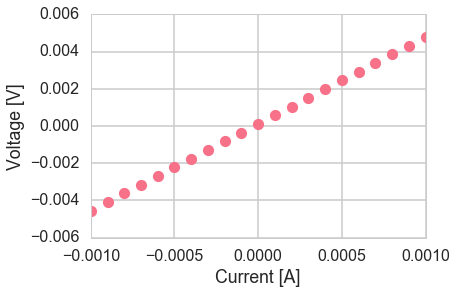

In [150]:
%matplotlib inline
path = '/Users/nakayamahidenori/my_python_modules/GPIB connection test'
filename = 'conductivity_test_tlink'
df = c_lab_conductivity(path, filename)

In [153]:
K2400.timeout

3000L